Autor: lmahdi zouine 

## Main objective of the analysis :
In this project is focused to predict stock market indices using Arima and recurrent neural network (RNN) and Long Short-Term Memory (LSTM) .

## Description: 
The art of forecasting stock prices has been a difficult task for many of the researchers and analysts. In fact, investors are highly interested in the research area of stock price prediction. For a good and successful investment, many investors are keen on knowing the future situation of the stock market. Good and effective prediction systems for the stock market help traders, investors, and analyst by providing supportive information like the future direction of the stock market.

__Describing the data:__

- The dataset for this project originates from kaggle.
- This data set contains  daily data from 2012 to 2016.
- As seen in the attached image, we have 6 columns of which we will only use the date field as the index of the series and the  Close field to predict its value

 

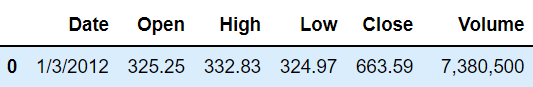


## Exploratory Data Analysis

* Import library and the csv file and examine its contents.
* Check data
* Check variable data types .
* Check missing values .
* Set_index for a time series


### Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv('Google_Stock_Price_Data.csv',sep=',')
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


#### Ckeck data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


- Change date to datetime using pandas
- set index 

In [6]:

data['Date']=pd.to_datetime(data.Date)

In [7]:
data.set_index('Date',inplace=True)

In [8]:
#data.index.nunique()

In [9]:
new_data=pd.DataFrame({'Close':data['Close']})
new_data.head()

,Close
Date,
2012-01-03,663.59
2012-01-04,666.45
2012-01-05,657.21
2012-01-06,648.24
2012-01-09,620.76


- Convert type object to float
- replace comma with white space

In [11]:
new_data.min()
#must te romove coma

Close    1,000.55
dtype: object

In [12]:
new_data['Close']=new_data.Close.str.replace(',','')
new_data['Close']=new_data.Close.apply(lambda x :float(x))

In [13]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


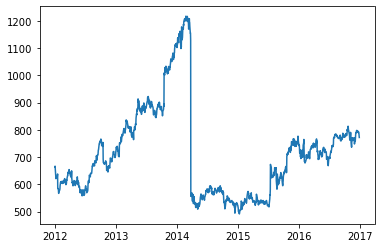

In [15]:
plt.figure()
plt.plot(new_data.index,new_data['Close'])
plt.show()

__Summary Key Findings and Insights :__
- At first glance, it can be said that the trend predominates since it seems that the trend has the same unit as the series .
- It seems that the series is not stationary.


<AxesSubplot:>

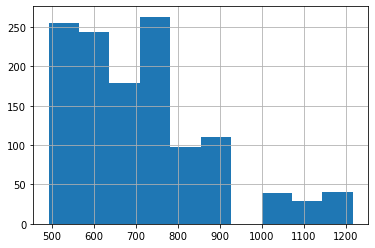

In [22]:
new_data.Close.hist()

__We are going to apply the logarithm to work with small values__

In [16]:
new_data['logClose']=np.log(new_data['Close'])
new_data.head()

,Close,logClose
Date,,
2012-01-03,663.59,6.497664
2012-01-04,666.45,6.501965
2012-01-05,657.21,6.488004
2012-01-06,648.24,6.474261
2012-01-09,620.76,6.430945



__We are going to draw the first 120 days to see how the trend is and if seasonality can be detected__

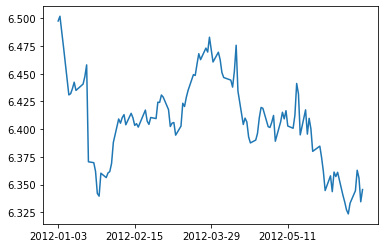

In [18]:
plt.plot(new_data['logClose'][:120])
plt.xticks(ticks = new_data.iloc[0:120:30].index)
plt.show()

__Summary Key Findings and Insights :__
-As we can see, the model is multiplicative  .

__Note:__
In the multiplicative model, the original time series is expressed as the product of trend, seasonal and irregular components. Under this model, the trend has the same units as the original series, but the seasonal and irregular components are unitless factors, distributed around 1

__We are going to decompose the series into trend, seasonality and residual .__


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
ss_decomposition_mul = seasonal_decompose(x=new_data.logClose,model='multiplicative',period=60)

estimated_trend_mul = ss_decomposition_mul.trend
estimated_seasonal_mul = ss_decomposition_mul.seasonal
estimated_residual_mul = ss_decomposition_mul.resid

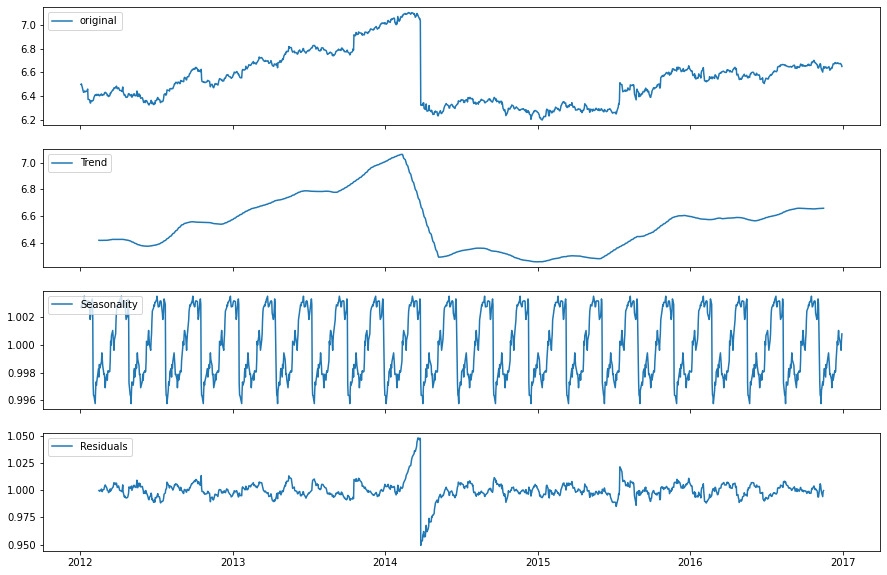

In [25]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(new_data.logClose, label='original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend_mul, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal_mul, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual_mul, label='Residuals')
axes[3].legend(loc='upper left');

**Now to eliminate the trend we can choose several methods, of which use the combination of residual and seasonality or divide on the trend**

In [26]:
new_data['Stationary']=(new_data.logClose/estimated_trend_mul)

**According to the graph below it seems that our series is stationary but we will still submit it to the Dickey-Fuller test**

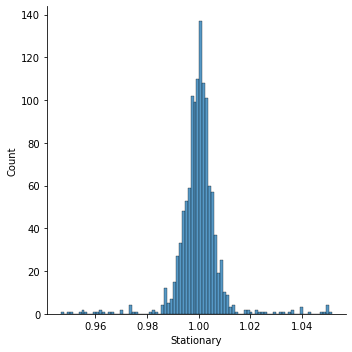

In [29]:
#new_data.Stationary.hist()
import seaborn as sns 
sns.displot(new_data.Stationary)

In [36]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -7.955171e+00
p-value                 3.050987e-12
Lags Used               1.000000e+01
Observations Used       1.187000e+03
Critical Value (1%)    -3.435871e+00
Critical Value (5%)    -2.863978e+00
Critical Value (10%)   -2.568068e+00
dtype: float64


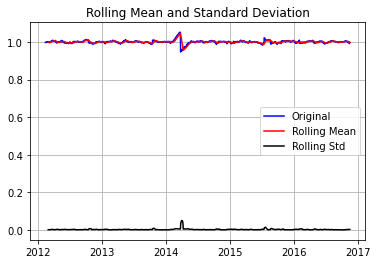

In [37]:
dftest(new_data.Stationary.dropna())

**we know that the series is stationary, now we will use ARIMA**

## MODEL ARIMA
- Plot acf,pcaf to indicated model
- Arma params .
- Sarimax 


In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

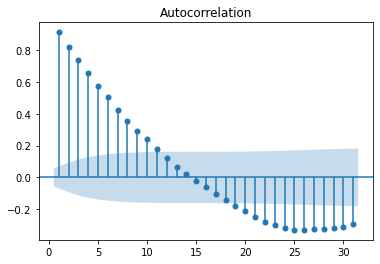

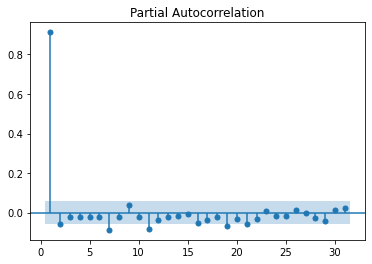

In [41]:
fig=plot_acf(new_data.Stationary.dropna(),zero=False)
fig=plot_pacf(new_data.Stationary.dropna(),zero=False);

**looks like an ar1 model without seasonal differencing**

In [42]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
model1 = sm.tsa.ARMA(new_data.logClose, (2,0)).fit(trend='nc', disp=0)
model1.params

ar.L1.logClose    1.031282
ar.L2.logClose   -0.031289
dtype: float64

### Sarimax
- p=1,q=0,d=0 
- Seasonal 12 but has not effect .

In [48]:
sar1 = sm.tsa.statespace.SARIMAX(new_data.logClose, 
                                order=(1,0,0), 
                                seasonal_order=(0,0,0,12), 
                                trend='c').fit()


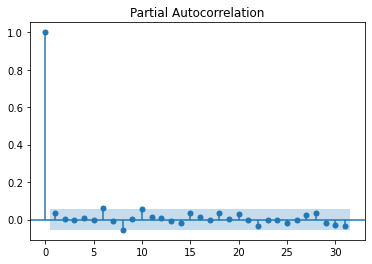

In [49]:
sm.tsa.graphics.plot_pacf(sar1.resid[sar1.loglikelihood_burn:]);

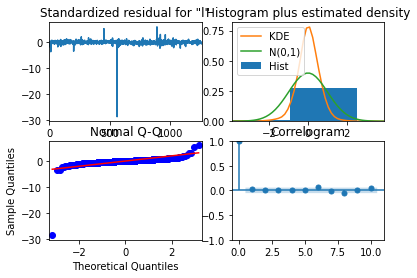

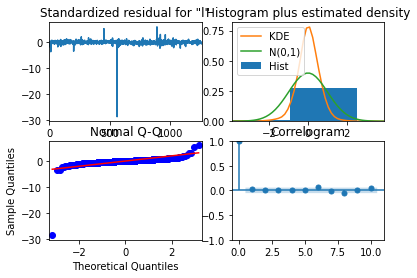

In [50]:
sar1.plot_diagnostics()

### Make prediction 

***
x=exp(log x)

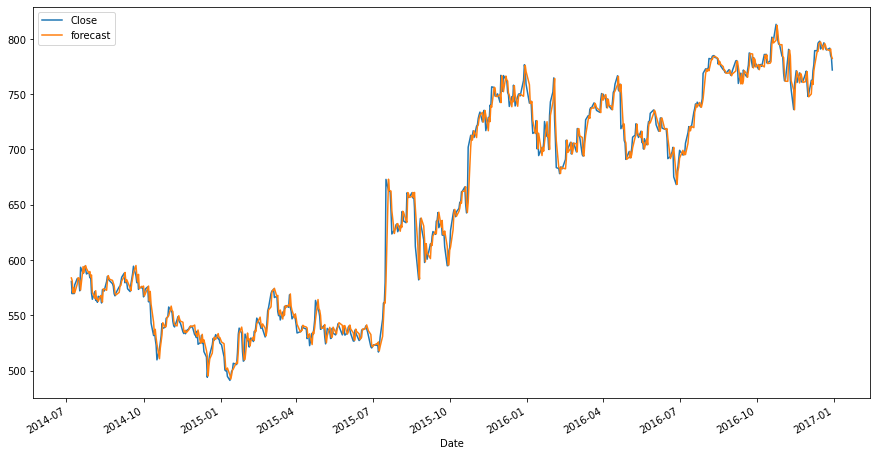

In [53]:
# plot predictions
pd.plotting.register_matplotlib_converters()

new_data['forecast']= np.exp(sar1.predict(start =new_data.index[int(len(new_data.Close)*.50)], end=new_data.index[int(len(new_data.Close))-1]))
#plt.figure(figsize=(15,8))
new_data[new_data.index[int(len(new_data.Close)*.50)]:][['Close','forecast']].plot(figsize=(15,8))
plt.show()

## Simple RNN

 - Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape [n_samples, time_steps, features] .  
 - We will build a recurrent neural network and train it to forecast a single time series
 - split data in train and test 
 -Make a Prediction. 

In [55]:
#50 days
horizon = 50

In [57]:
train = new_data[:len(new_data)-horizon]['Close'].values# to array shape (1208,)
test = new_data[len(train):]['Close'].values
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

***Scaling or normalizing the data is recommended because randomly initialized weights  may not be able to get along with feature scale very well, and may cause the activations to saturate.***

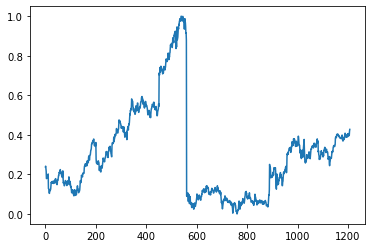

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train

plt.plot(train_scaled)
plt.show()


In [61]:
train_scaled.shape

(1208, 1)

__Inputs for RNN X_train,y_train__
- Each training sample is of length steps ->0:50,1:51...
- Each y is just the next step after training sample 50,51,...        

In [60]:
train_X = []
train_y = []
steps=50
for i in range(0, train_scaled.shape[0]-steps): 
        train_X.append(train_scaled[i:i+steps,0]) # each training sample is of length steps ->0:50,1:51...
        train_y.append(train_scaled[i+steps,0]) # each y is just the next step after training sample 50,51,...

In [62]:
type(train_X)

list

In [63]:
#list -->array
train_y=np.array(train_y)


In [64]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

In [65]:
X_train = get_keras_format_series(train_X)

In [66]:
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(train_y.shape))

Training input shape: (1158, 50, 1)
Training output shape: (1158,)


***__Inputs for prediction X_Test***

In [68]:
#test
testing = new_data[len(new_data) - len(test) - horizon:]['Close'].values
testing=testing.reshape(testing.shape[0],1)
testing = scaler.transform(testing)

test_X = []

for i in range(0,horizon):
    test_X.append(testing[i:i+horizon,0])

X_test=get_keras_format_series(test_X)    


In [78]:
print(X_test.shape)
print(test.shape)

(50, 50, 1)
(50, 1)


__Import library__

In [79]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from sklearn.metrics import mean_squared_error

- Trying diferent sizes of the RNN hidden dimension
- activation relu
- return_sequence must to set TRUE -> return_sequences: Boolean. Whether to return the last output
    in the output sequence, or the full sequence.
- Dropout     
- loss function mean_squared_error
- optimezer adam .

In [80]:
model = Sequential() 

model.add(SimpleRNN(70, activation='relu', input_shape=(X_train.shape[1],1),return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='relu',return_sequences = True))
model.add(Dropout(0.25))
model.add(SimpleRNN(50, activation='relu',return_sequences = True))
model.add(Dropout(0.25))
model.add(SimpleRNN(50, activation='relu'))#return_sequence=false dense(non,1) else dense shape (non,50,1)
# output layer to make final predictions 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, train_y, epochs=60, batch_size=32, verbose=0)

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 70)            5040      
                                                                 
 dropout (Dropout)           (None, 50, 70)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            6050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

### Make prediction

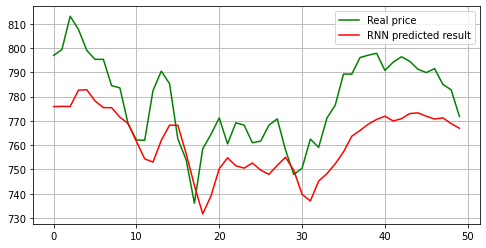

In [84]:
#PREDICTION
pred = model.predict(X_test)#DATA SCALED
pred = scaler.inverse_transform(pred)
plt.figure(figsize=(8,4))

plt.plot(test,color="g",label="Real price")
plt.plot(pred,color="r",label="RNN predicted result")
plt.legend()
plt.grid(True)
plt.show()

__Summary Key Findings and Insights :__
We can see that our recurrent neural network has done a good job knowing the amount of information hidden underneath, without knowing anything about the trend or seasonality etc...But have Disadvantages: 
- Gradient exploding and vanishing problems.
- Training an RNN is a completely tough task.
- It cannot system very lengthy sequences if the usage of Tanh or Relu as an activation feature.

### LSTM
- We use everything the same as RNN except for the LSTM model that will be different
- 50 hidden layers
- loss function mean_squared_error .
- optimizer: adam

In [85]:
from keras.layers import LSTM

In [568]:
Lstm_model = Sequential()
Lstm_model.add(LSTM(50,input_shape=(X_train.shape[1],1))) 
Lstm_model.add(Dense(1))
Lstm_model.compile(loss='mean_squared_error', optimizer='adam')
Lstm_model.fit(X_train, train_y, epochs=60, batch_size=32,verbose=False)

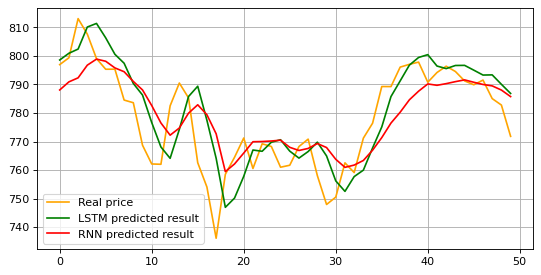

In [569]:
#PREDICTION
pred2 = Lstm_model.predict(X_test)#DATA SCALED
pred2 = scaler.inverse_transform(pred2)


plt.plot(test,color="orange",label="Real price")
plt.plot(pred2,color="g",label="LSTM predicted result")
plt.plot(pred,color="r",label="RNN predicted result")
plt.legend()
plt.grid(True)
plt.show()

__Summary Key Findings and Insights :__
- Can be more expressive than simple RNNs 
- LSTM  has done an excellent job with a very simple structure

## Results
- Take a look at the model summary and compare it with the summary for our simple RNN . You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.
- LSTM IS BETTER THAN RNN
- MODEL ARIMA HAS DONE AN EXCELLENT JOB WITH FEW PARAMETERS, THAT LEADS US TO THE CONCLUSION THAT IT IS BETTER TO ANALYZE THE SERIES BEFORE CHOOSING ANY MODEL .
- I __WOULD RECOMMEND__ THE ARIMA MODEL FOR ITS SIMPLICITY AND ITS INTERPRETATION, THAT DOES NOT MEAN THAT RNN OR LSTM ARE LESS GOOD AS THERE ARE COMPLEX CASES THAT ONLY LSTM CAN ACHIEVE A DECENT RESULT .

## Next Steps


- training(Rnn) with more data, try increasing cell_units and running more training epochs,other optimezer,activation function.
- Try using longer input sequences with LSTM, and predicting a wider range of test .
- using another variable exogenous 
- Use other parameter (p,d,q) or use autoarima to get the best parameters .
- Use skforecast is a python library that eases using scikit-learn regressors as multi-step forecasters. It also works with any regressor compatible with the scikit-learn API (pipelines, CatBoost, LightGBM, XGBoost, Ranger...).
 https://joaquinamatrodrigo.github.io/skforecast/0.4.2/index.html 